In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow import keras
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import data.preprocess as pre
import optuna

In [10]:
file = pd.read_json("data.json") #using the MSFT data
SET_ESS = ["date", "close", "high", "low", "open", "symbol", "volume", "change", "changePercent"]
data = pd.DataFrame(file['GOOG']['chart'])[SET_ESS]
pre.apply_indicators(data)
data.set_index('date',inplace = True)
data = data.filter(['close','ma_cross','macd_cross','rsi'])
data.dropna(inplace=True)
data_len = len(data.values)
feature = 4

In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)
# predict 360 days
test_size = 360

# 14 days to predict the next day (sliding window)
window = 7
#split the train data 
train_data = scaled_data[0:data_len-test_size-window,:]
x_train = []
y_train = []
for i in range(window, len(train_data)): 
  x_train.append(train_data[i-window:i, :]) 
  y_train.append(train_data[i][0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature))

#split the test_data (for validation)
test_data = scaled_data[data_len-(window+test_size):data_len,:]

x_test = []
y_test = []

for i in range(window, len(test_data)): #run from 14, 15 , 16 ... len(test_data)-1
  x_test.append(test_data[i-window:i, :])
  y_test.append(test_data[i][0])
  
x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature))

print(x_test[-1])
print(y_test[-1])


#predict future +1 day value
x_future = []
x_future.append(test_data[len(test_data)-window:len(test_data),:])
x_future= np.array(x_future)
x_future = np.reshape(x_future, (x_future.shape[0], x_future.shape[1], feature))




[[ 5.20455324e-01  3.25869500e-03 -2.68998043e-03 -1.16639570e+00]
 [ 4.59731889e-01  3.25869500e-03 -2.68998043e-03 -1.41263255e+00]
 [ 5.80913010e-01  3.25869500e-03 -2.68998043e-03 -7.55334451e-01]
 [ 5.31218121e-01 -3.98212529e+00 -2.68998043e-03 -9.71447707e-01]
 [ 4.78600002e-01  3.25869500e-03  3.28715609e+00 -1.19292037e+00]
 [ 3.71370655e-01  3.25869500e-03 -2.68998043e-03 -1.60406715e+00]
 [ 2.93639343e-01  3.25869500e-03 -2.68998043e-03 -1.86914698e+00]]
0.388511405415976


In [12]:
from sklearn.metrics import mean_squared_error
from tensorflow import optimizers
from keras.callbacks import EarlyStopping
predict = data[data_len-test_size:data_len]

early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

# Objective function(optuna)
# for anyone looking at this part, please run it when you have plenty of time, becasue it will take one hour :(
def run(trial):
    space = {
        'optimizer':  trial.suggest_categorical('optimizer', [keras.optimizers.Adam, keras.optimizers.Adagrad, keras.optimizers.Adamax, keras.optimizers.Nadam, keras.optimizers.RMSprop, keras.optimizers.SGD]),
        'units_1': trial.suggest_int('units_1', 100, 250, 50),
        'dropout_rate_1': trial.suggest_float('dropout_rate_1', 0.1, 0.6),
        'epochs': trial.suggest_int('epochs', 100, 250, 50),
        'batch_size': trial.suggest_categorical('batch_size', [128, 256]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.01)
    }

    model = Sequential()

    model.add(LSTM(units=space['units_1'], return_sequences = True, input_shape=(x_train.shape[1], feature)))
    model.add(Dropout(rate=space['dropout_rate_1']))
    model.add(LSTM(units=space['units_1']))
    model.add(Dropout(rate=space['dropout_rate_1']))
    model.add(Dense(units=14))
    model.add(Dense(units=1))
        
    model.compile(loss='mean_squared_error', optimizer=space['optimizer'](learning_rate=space['learning_rate']), metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=space['epochs'], validation_data=(x_test, y_test), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)
    
    predictions = model.predict(x_test)
    Predict_dataset_3D = np.zeros(shape=(len(predictions), feature))
    Predict_dataset_3D[:,0] = predictions[:,0]
    predictions = scaler.inverse_transform(Predict_dataset_3D)[:,0]
    
    
    mape = mean_absolute_percentage_error(predict['close'].values, predictions)
    r2 = r2_score(predict['close'].values, predictions)
    
    return mape,r2

study = optuna.create_study(directions=["minimize","maximize"])
study.optimize(run, n_trials=5)



[I 2022-11-13 14:53:50,656] A new study created in memory with name: no-name-f919b011-213c-4c93-8044-4185cb1e4bdf
C:\Users\lawre\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.optimizers.optimizer_experimental.adam.Adam'> which is of type type.
  warnings.warn(message)
C:\Users\lawre\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.optimizers.optimizer_experimental.adagrad.Adagrad'> which is of type type.
  warnings.warn(message)
C:\Users\lawre\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for per

ValueError: in user code:

    File "c:\Users\lawre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\lawre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lawre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\lawre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\lawre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lawre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 7, 3), found shape=(None, 7, 4)


In [ ]:
best_params = min(study.best_trials, key=lambda t: t.values[0]).params 
#chosing the smaller mape has higher priority than chosing the larger r2_score
best_params

NameError: name 'study' is not defined

In [ ]:

""""
model= Sequential()

model.add(LSTM(units=150, return_sequences=True,input_shape=(x_train.shape[1],3)))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=150, input_shape=(x_train.shape[1],3)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=14))
model.add(Dense(units=1))


model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=50)

"""
model= Sequential()

model.add(LSTM(units=best_params['units_1'], return_sequences=True, input_shape=(x_train.shape[1],feature)))
model.add(Dropout(rate=best_params['dropout_rate_1']))

model.add(LSTM(units=best_params['units_1'], input_shape=(x_train.shape[1],feature)))
model.add(Dropout(rate=best_params['dropout_rate_1']))
model.add(Dense(units=14))
model.add(Dense(units=1))


model.summary()
model.compile(loss='mean_squared_error', optimizer=best_params['optimizer'](learning_rate=best_params['learning_rate']))
model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=best_params['epochs'], batch_size=best_params['batch_size'] )


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 14, 150)           92400     
                                                                 
 dropout_50 (Dropout)        (None, 14, 150)           0         
                                                                 
 lstm_51 (LSTM)              (None, 250)               401000    
                                                                 
 dropout_51 (Dropout)        (None, 250)               0         
                                                                 
 dense_50 (Dense)            (None, 14)                3514      
                                                                 
 dense_51 (Dense)            (None, 1)                 15        
                                                                 
Total params: 496,929
Trainable params: 496,929
Non-t

12/12 [==============================] - 1s 19ms/step
r2_score:  0.927446303055687
MAPE:  0.021871434743899843
MAE:  6.250417877347493
MSE:  60.26616283422474
rmse:  7.763128417991341


C:\Users\lawre\AppData\Local\Temp\ipykernel_32820\2658663640.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['Predictions'] = predictions


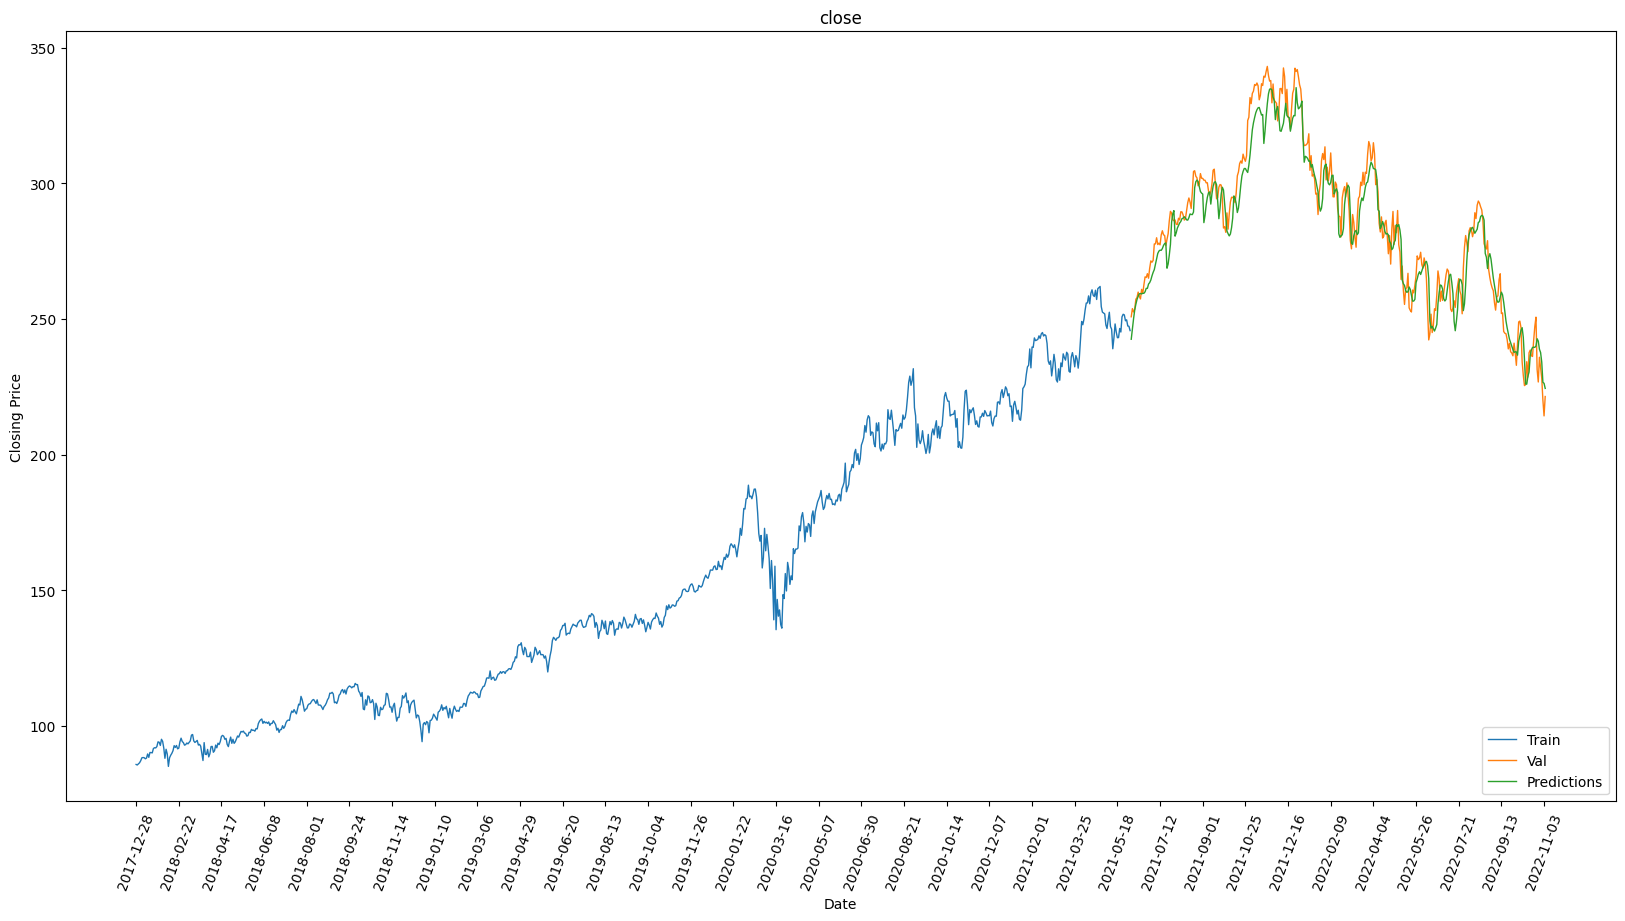

             close  Predictions
date                           
2021-06-04  250.79   242.509590
2021-06-07  253.81   246.236703
2021-06-08  252.57   249.992018
2021-06-09  253.59   253.218045
2021-06-10  257.24   255.387337
...            ...          ...
2022-10-31  232.13   237.623576
2022-11-01  228.17   234.092228
2022-11-02  220.10   226.627770
2022-11-03  214.25   226.268296
2022-11-04  221.39   224.394754

[360 rows x 2 columns]


In [ ]:
predictions = model.predict(x_test)
Predict_dataset_3D = np.zeros(shape=(len(predictions), feature) )
Predict_dataset_3D[:,0] = predictions[:,0]

predictions = scaler.inverse_transform(Predict_dataset_3D)[:,0]
train = data[:data_len-test_size]
predict = data[data_len-test_size:data_len]
predict['Predictions'] = predictions

print('r2_score: ',r2_score(predict['close'].values, predictions))
print('MAPE: ',mean_absolute_percentage_error(predict['close'].values, predictions))
# It is the average of the percentage errors.
print('MAE: ', mean_absolute_error(predict['close'].values, predictions))
#an average of the absolute errors
print('MSE: ', mean_squared_error(predict['close'].values, predictions,squared=True))
#The MSE is the average squared distance between the observed and predicted values.
print('rmse: ',mean_squared_error(predict['close'].values, predictions,squared=False))

plt.figure(figsize=(20,10))
plt.title('close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train['close'],linewidth=1)
plt.plot(predict[['close','Predictions']],linewidth=1)
plt.xticks(np.arange(0, len(data.values)+1,37),rotation=70)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

print(predict[['close','Predictions']])


In [ ]:
predictions2 = model.predict(x_future)
Predict_dataset_3D = np.zeros(shape=(len(predictions2), feature) )
Predict_dataset_3D[:,0] = predictions2[:,0]
predictions2 = scaler.inverse_transform(Predict_dataset_3D)[:,0]
print(predictions2)

1/1 [==============================] - 0s 16ms/step
[223.39689894]


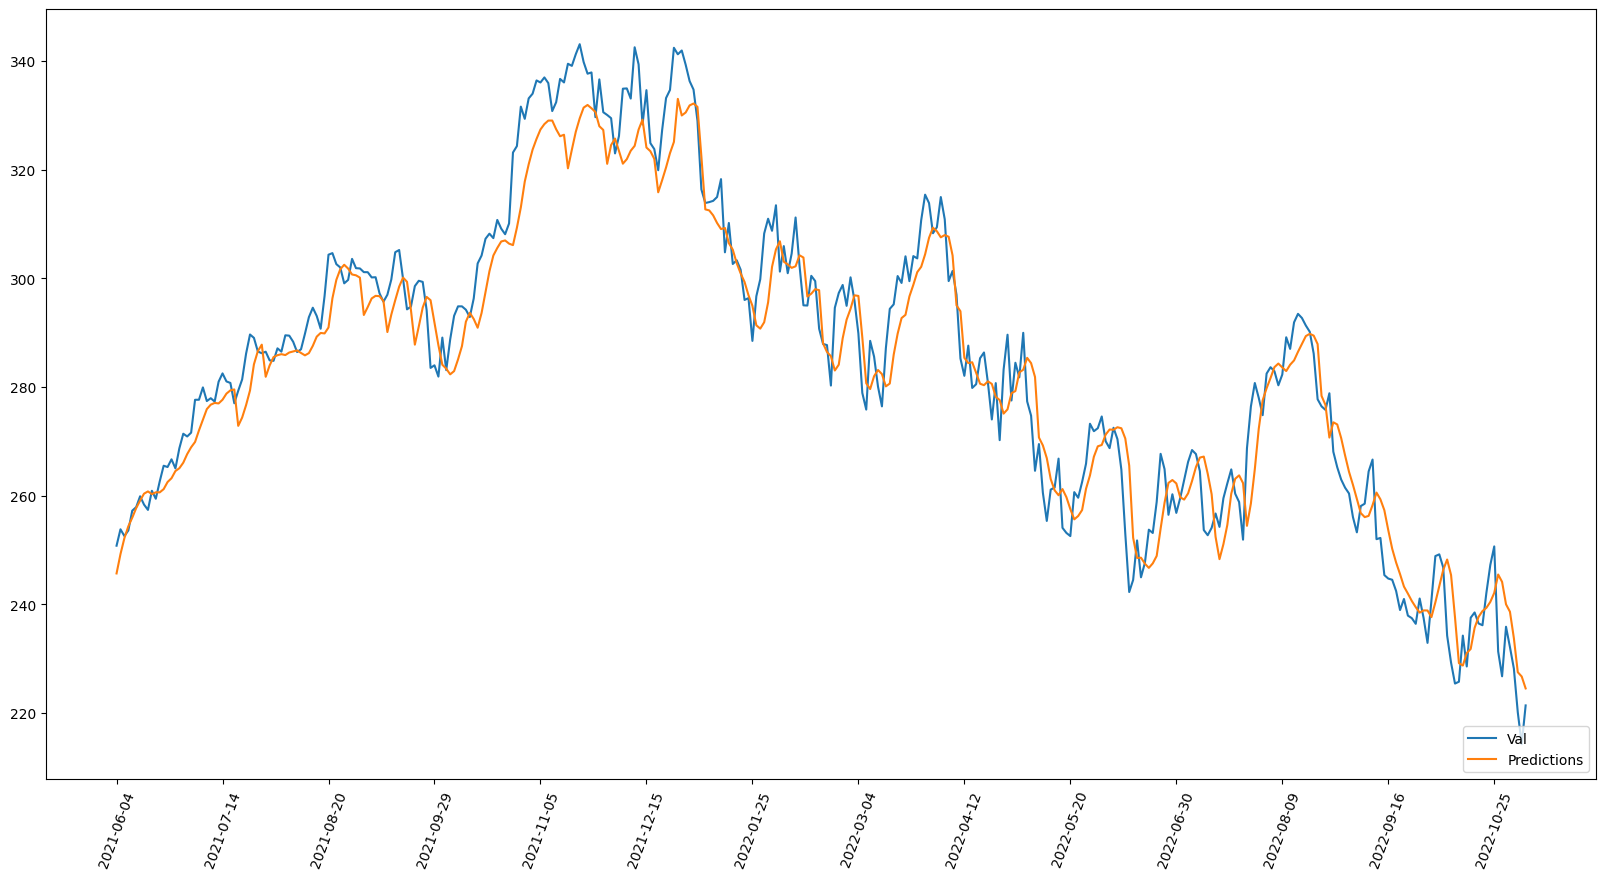

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, len(predict)+1,27),rotation=70)
plt.plot(predict[['close','Predictions']],linewidth=1.5)
plt.legend(['Val','Predictions'], loc = 'lower right')